In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FactorAnalysis

from tqdm import tqdm, trange
# import plotly.express as px
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
for style in plt.style.available:
    print(style)
plt.style.use('seaborn-paper')

Solarize_Light2
_classic_test_patch
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn
seaborn-bright
seaborn-colorblind
seaborn-dark
seaborn-dark-palette
seaborn-darkgrid
seaborn-deep
seaborn-muted
seaborn-notebook
seaborn-paper
seaborn-pastel
seaborn-poster
seaborn-talk
seaborn-ticks
seaborn-white
seaborn-whitegrid
tableau-colorblind10


In [3]:
raw_influence_data = pd.read_csv("influence_data.csv")
m = np.shape(raw_influence_data)[0]
musician_dict = dict()
genre_scale_evolve = pd.DataFrame(np.zeros((n_genres, 9)), index = genres, columns = list(range(1920, 2010, 10)))

for i in range(m):
    g1 = raw_influence_data["influencer_main_genre"][i]
    y1 = (raw_influence_data["influencer_active_start"][i] // 10) * 10
    g2 = raw_influence_data["follower_main_genre"][i]
    y2 = (raw_influence_data["follower_active_start"][i] // 10) * 10
    if musician_dict.get(raw_influence_data["influencer_id"][i], -1) == -1:
        musician_dict[raw_influence_data["influencer_id"][i]] = g1
        if y1 < 2010:
            genre_scale_evolve.loc[g1][y1] += 1
    if musician_dict.get(raw_influence_data["follower_id"][i], -1) == -1:
        musician_dict[raw_influence_data["follower_id"][i]] = g2
        if y2 < 2010:
            genre_scale_evolve.loc[g2][y2] += 1

NameError: name 'n_genres' is not defined

In [4]:
info_columns = ["danceability", "energy", "valence", "tempo", "loudness", "mode", "key", "acousticness",
                "instrumentalness", "liveness", "speechiness", "duration_ms"]

raw_full_data = pd.read_csv("full_music_data.csv")
release_dates = []
for date in raw_full_data["release_date"].values:
    year = date.rstrip(' ')[-2:]
    y = int(year)
    if y < 20:
        y = 2000+(y//10)*10
    else:
        y = 1900+(y//10)*10
    release_dates.append(y)
raw_full_data["release_date"] = release_dates

artists_id = raw_full_data["artists_id"].values
genre_list = []
n = np.shape(artists_id)[0]
for i in range(n):
    temp, flag = artists_id[i][1:-1].split(','), False
    for x in temp:
        if musician_dict.get(int(x.lstrip(' ')), -1) != -1:
            genre_list.append(musician_dict[int(x.lstrip(' '))])
            flag = True
            break
    if not flag:
        genre_list.append("Unknown")

genres = pd.unique(genre_list)
n_genres = len(genres)

In [5]:
raw_data_artist = pd.read_csv("data_by_artist.csv")

scaler = MinMaxScaler()
X = scaler.fit_transform(raw_data_artist[info_columns].values)

dimension_reducer = load("P2_FA.joblib")
Z = dimension_reducer.transform(X)

I tried both raw data $X$ and transformed data $XC^T$ whose coefficients $C^T$ are provided by Factor Analysis in Problem 2.  
The result shows that with linear transform by FA, the divergences between genres are larger and within a genre are smaller.

In [6]:
musician_embedding = dict()
genre_dict = {g: [] for g in genres}

for i in range(np.shape(raw_data_artist)[0]):
    if musician_dict.get(raw_data_artist["artist_id"][i], -1) != -1:
        musician_embedding[raw_data_artist["artist_id"][i]] = Z[i, :]
        genre_dict[musician_dict[raw_data_artist["artist_id"][i]]].append(raw_data_artist["artist_id"][i])

In [7]:
n_musicians = np.shape(raw_data_artist)[0]

diff = np.zeros((n_musicians, n_musicians))

temp = raw_data_artist[info_columns].values
xx = MinMaxScaler().fit_transform(temp)
zz = dimension_reducer.transform(xx)
for j in trange(n_musicians):
    for k in range(n_musicians):
        diff[j][k] = np.exp(-np.linalg.norm(zz[j] - zz[k], 2)**2 / 8)
df = pd.DataFrame(diff, index = raw_data_artist["artist_id"].values, columns = raw_data_artist["artist_id"].values)
df.to_csv("similarity.csv")

100%|██████████| 5854/5854 [04:33<00:00, 21.40it/s]


<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-11-1a20166293dc>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if genre == g and musician_embedding.get(artist, -1) is not -1:


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

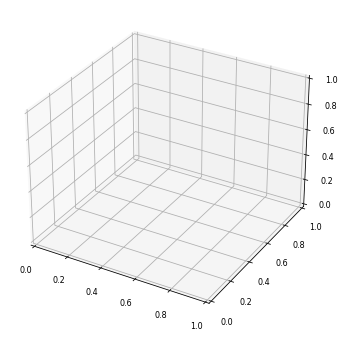

In [11]:
if dimension_reducer.n_components == 3:
    fig = plt.figure()
    ax = Axes3D(fig)
else:
    plt.figure()
for g in genres:
    embeddings = []
    for artist, genre in musician_dict.items():
        if genre == g and musician_embedding.get(artist, -1) is not -1:
            embeddings.append(musician_embedding[artist])
    temp = np.array(embeddings)
    if dimension_reducer.n_components == 3:
        ax.scatter3D(temp[:, 0], temp[:, 1], temp[:, 2])
    else:
        x, y = musician_embedding[artist]
        plt.scatter(temp[:, 0], temp[:, 1])
# plt.legends = genres
plt.show()

In [ ]:
# for g1 in tqdm(genres):
similarity_matrix = pd.DataFrame(columns = genres, index = genres, dtype = float)
for g1 in genres:
    for g2 in genres:
        g1_artists, g2_artists = genre_dict[g1], genre_dict[g2]
        g1_embedding, g2_embedding = [], []
        for artist in g1_artists:
            g1_embedding.append(musician_embedding[artist])
        for artist in g2_artists:
            g2_embedding.append(musician_embedding[artist])
        g1_embedding, g2_embedding = np.array(g1_embedding), np.array(g2_embedding)
#       Gaussian similarity
        sim = np.zeros((len(g1_embedding), len(g2_embedding)))
        for i in range(len(g1_embedding)):
            sim[i, :] = np.exp(-np.linalg.norm(g1_embedding[i]-g2_embedding, 2, axis = 1)**2 / 0.18)
        similarity_matrix[g1][g2] = np.mean(sim[:])

#       Cosine similarity
#         g1_norm = np.linalg.norm(g1_embedding, 2, axis = 1, keepdims = True)
#         g2_norm = np.linalg.norm(g2_embedding, 2, axis = 1, keepdims = True)
#         denominator = np.dot(g1_norm, g2_norm.T)
#         similarity_matrix[g1][g2] = np.mean((np.dot(g1_embedding, g2_embedding.T)/denominator)[:])

In [ ]:
fig = px.imshow(similarity_matrix)
fig.show()

# fig, ax = plt.subplots()
# im = ax.imshow(similarity_matrix)
# ax.set_xticks(np.arange(len(genres)))
# ax.set_yticks(np.arange(len(genres)))
# ax.set_xticklabels(genres)
# ax.set_yticklabels(genres)
# plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
#          rotation_mode="anchor")
# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel("", rotation=-90, va="bottom")
# plt.show()

In [ ]:
nodes_data = pd.read_csv("size.csv", header = None)
edges_data = pd.read_csv("edge.csv", index_col = 0)

m = np.shape(nodes_data)[0]
nodes = pd.DataFrame(index = list(range(m)), columns = ["id", "value", "category", "label"])

for i in range(m):
    nodes.iloc[i]["id"] = nodes_data.iloc[i][0]
    nodes.iloc[i]["category"] = nodes_data.iloc[i][0]
    nodes.iloc[i]["value"] = nodes_data.iloc[i][1]
    nodes.iloc[i]["label"] = nodes_data.iloc[i][0]

nodes.to_csv("nodes.csv", index = False)

In [ ]:
total_edges, cnt = np.sum((edges_data.values != 0)[:]), 0
edges = pd.DataFrame(index = list(range(total_edges)), columns = ["source", "target", "weight"])

for g1 in genres:
    for g2 in genres:
        if edges_data.loc[g1][g2] != 0:
            edges.iloc[cnt]["source"] = g1
            edges.iloc[cnt]["target"] = g2
            edges.iloc[cnt]["weight"] = edges_data.loc[g1][g2]
            cnt += 1

edges.to_csv("edges.csv", index = False)

In [ ]:
data = "["
node2idx = dict()
for i in range(m):
    data += "{\n"
    data += "name: \'" + nodes.iloc[i]["id"] + "\'\n}, "
    node2idx[nodes.iloc[i]["id"]] = str(i)
# print(data[:-2] + ']')
# print(node2idx)
"""
    source: 0,
    target: 1,
    symbolSize: [5, 20],
    label: {
        show: true
    },
    lineStyle: {
        width: 5,
        curveness: 0.2
    }
"""
# max_weight = edges.values[:, 2].astype(float).max()
links = "["
for i in range(total_edges):
    links += "{\n"
    links += "source: \'" + edges.iloc[i]["source"].replace('\'', '\\\'') + "\',\n"
    links += "target: \'" + edges.iloc[i]["target"].replace('\'', '\\\'') + "\',\n"
    links += "lineStyle: {\n\twidth: " + str(int(np.log(edges.values[i][2])* 2.5)) + ",\n\tcurveness: 0.2\n}\n}, "
    
print(links[:-2] + ']')

In [ ]:
print('\\\'')

In [ ]:
genre_embedding = pd.DataFrame(np.zeros((n_genres, 3)), index = genres, columns = ['Component_'+str(i) for i in [0, 1, 2]])
for g in genres:
    embedding = []
    for x in genre_dict[g]:
        embedding.append(musician_embedding[x])
    genre_embedding.loc[g] = np.mean(embedding, axis = 0)

In [ ]:
x_axis = range(1920, 2010, 10)

for j in [0, 1, 2, 3]:
    plt.figure(j)
    for g in genres[5*j : 5*j+5]:
        if g == "Unknown":
            continue
        y_axis = genre_scale_evolve.loc[g]
        plt.plot(x_axis, y_axis, '--o', linewidth = 2.5, markersize = 6, label = g)
    plt.xlabel("Decade", fontsize = 18)
    plt.ylabel("Number of Works", fontsize = 18)
    plt.grid(True, linestyle = '--')
    plt.tick_params(labelsize = 18)
    plt.legend(loc = 2, bbox_to_anchor = (1.05, 1.0), borderaxespad = 0, fontsize = 18)
plt.show()

In [ ]:
temp = raw_full_data["release_date"].values
temp = temp.reshape((temp.shape[0], 1))
X_ = MinMaxScaler().fit_transform(raw_full_data[info_columns].values)
Z_ = dimension_reducer.transform(X_)
new_data = np.hstack((temp, np.reshape(genre_list, (len(genre_list), 1)).astype(object), Z_))

new_data = pd.DataFrame(new_data, index = raw_full_data.index, \
                        columns = ["release_date", "genre"] + ["Components_"+str(i) for i in [0, 1, 2]], dtype = object)

In [ ]:
genre_work_evolve = pd.DataFrame(np.zeros((n_genres, 9)), index = genres, columns = list(range(1920, 2010, 10)))

for decade, table in new_data.groupby("release_date"):
    for g in genres:
        genre_work_evolve.loc[g][decade] = np.shape(table[table["genre"] == g])[0]

genre_work_evolve

In [ ]:
x_axis = range(1920, 2010, 10)

for j in [0, 1, 2, 3]:
    plt.figure(j)
    for g in genres[5*j : 5*j+5]:
        if g == "Unknown":
            continue
        y_axis = genre_work_evolve.loc[g]
        plt.plot(x_axis, y_axis, '--o', linewidth = 2.5, markersize = 6, label = g)
    plt.xlabel("Decade", fontsize = 18)
    plt.ylabel("Number of Works", fontsize = 18)
    plt.grid(True, linestyle = '--')
    plt.tick_params(labelsize = 18)
    plt.legend(loc = 2, bbox_to_anchor = (1.05, 1.0), borderaxespad = 0, fontsize = 18)
plt.show()

In [ ]:
genre_feature_evolve = pd.DataFrame(index = genres, columns = ["Component_"+str(i) for i in [0, 1, 2]], dtype = object)
for i in genre_feature_evolve.index:
    for j in genre_feature_evolve.columns:
        genre_feature_evolve.loc[i][j] = []

for decade, table in new_data.groupby("release_date"):
    for g in genres:
        temp = table[table["genre"] == g][["Components_"+str(i) for i in [0, 1, 2]]]
        # print(np.mean(temp.values.astype(float), axis = 0))
        if np.shape(temp)[0] != 0:
            embedding = np.mean(temp.values.astype(float), axis = 0)
            for i in range(3):
                genre_feature_evolve.loc[g]["Component_"+str(i)].append(embedding[i])
        else:
            for i in range(3):
                genre_feature_evolve.loc[g]["Component_"+str(i)].append(np.nan)

In [ ]:
for i in genre_feature_evolve.columns:
    for j in genre_feature_evolve.index:
        l = len(genre_feature_evolve[i][j])
        for k in range(l):
            if k > 0 and k < l and genre_feature_evolve[i][j][k] is np.nan:
                genre_feature_evolve[i][j][k] = (genre_feature_evolve[i][j][k-1] + genre_feature_evolve[i][j][k+1]) / 2

In [ ]:
x_axis = list(range(1920, 2011, 10))

for i in [0, 1, 2]:
    for j in [0, 1, 2, 3]:
        plt.figure(4*i+j)
        for g in genres[5*j : 5*j+5]:
            if g == "Unknown":
                continue
            y_axis = genre_feature_evolve.loc[g]["Component_"+str(i)]
            plt.plot(x_axis, y_axis, '--o', linewidth = 2.5, markersize = 6, label = g)
        plt.xlabel("Decade", fontsize = 18)
        plt.ylabel("Component "+str(i), fontsize = 18)
        plt.grid(True, linestyle = '--')
        plt.tick_params(labelsize = 18)
        plt.legend(loc = 2, bbox_to_anchor = (1.05, 1.0), borderaxespad = 0, fontsize = 16)
plt.show()